# 0. Gravitational waves classification

In this notebook, we attempt to build a neural network to classify gravitational waves and pure noise signals. 

Gravitational waves are disturbances in the curvature of spacetime, generated by accelerated masses, that propagate as waves outward from their source at the speed of light. Although they ripple, in real scenario most signals are obtained with noise and so they cannot be visually distinguished from noise signals. The gravitational waves are generated with using the [LALSuite IMRPhenomD generator](https://arxiv.org/pdf/1508.07250.pdf).

The aim of this work is to classify gravitation waves and pure noise signals using 1d convolutional and dense layers. 


In [ ]:
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Multiply, Add, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# sklearn
from sklearn import metrics
from sklearn import svm
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
import sklearn.datasets
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

# helpers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os.path import join


## Google Cloud Storage Boilerplate

The following two cells have some boilerplate to mount the Google Cloud Storage bucket containing the data used for this notebook to your Google Colab file system. **Even you are not using Google Colab, please make sure you run these two cells.** 

To access the data from Google Colab, you need to:

1. Run the first cell;
2. Follow the link when prompted (you may be asked to log in with your Google account);
3. Copy the Google SDK token back into the prompt and press `Enter`;
4. Run the second cell and wait until the data folder appears.

If everything works correctly, a new folder called `sciml-workshop-data` should appear in the file browser on the left. Depending on the network speed, this may take one or two minutes. Ignore the warning "You do not appear to have access to project ...". If you are running the notebook locally or you have already connected to the bucket, these cells will have no side effects.

In [ ]:
# variables passed to bash; do not change
project_id = 'sciml-workshop'
bucket_name = 'sciml-workshop'
colab_data_path = '/content/sciml-workshop-data/'

try:
    from google.colab import auth
    auth.authenticate_user()
    google_colab_env = 'true'
    data_path = colab_data_path
except:
    google_colab_env = 'false'
    ###################################################
    ######## specify your local data path here ########
    ###################################################
    with open('../local_data_path.txt', 'r') as f: data_path = f.read().splitlines()[0]

In [ ]:
%%bash -s {google_colab_env} {colab_data_path} {project_id} {bucket_name}

# running locally
if ! $1; then
    echo "Running notebook locally."
    exit
fi

# already mounted
if [ -d $2 ]; then
    echo "Data already mounted."
    exit
fi

# mount the bucket
echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
apt -qq update
apt -qq install gcsfuse
gcloud config set project $3
mkdir $2
gcsfuse --implicit-dirs --limit-bytes-per-sec -1 --limit-ops-per-sec -1 $4 $2

OK
75 packages can be upgraded. Run 'apt list --upgradable' to see them.
The following package was automatically installed and is no longer required:
  libnvidia-common-470
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 newly installed, 0 to remove and 75 not upgraded.
Need to get 12.0 MB of archives.
After this operation, 28.6 MB of additional disk space will be used.
Selecting previously unselected package gcsfuse.
(Reading database ... 155320 files and directories currently installed.)
Preparing to unpack .../gcsfuse_0.40.0_amd64.deb ...
Unpacking gcsfuse (0.40.0) ...
Setting up gcsfuse (0.40.0) ...
2022/03/04 13:36:39.925217 Start gcsfuse/0.40.0 (Go version go1.17.6) for app "" using mount point: /content/sciml-workshop-data
2022/03/04 13:36:39.941401 Opening GCS connection...
2022/03/04 13:36:40.182025 Mounting file system "sciml-workshop"...
2022/03/04 13:36:40.214696 File system has been successfully mounted.


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2537  100  2537    0     0  68567      0 --:--:-- --:--:-- --:--:-- 68567




Updated property [core/project].


---

# 1. Load the dataset

### Read raw data

The data is stored in 'Physics/gravitational_wave_dataset.npz', containing 2,000 signals: 1,000 examples of signals and 1,000 examples of pure noise. The signals are 1 second long with a sample rate of 8196.

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
grav_wave = np.load(join(data_path, 'Physics/gravitational_wave_dataset.npy'), allow_pickle=True)
```
    
</p>
</details>

In [ ]:
grav_wave = np.load(join(data_path, 'Physics/gravitational_wave_dataset.npy'), allow_pickle=True)

In [ ]:
def prepare_datset(X, target = 'regression'):
    if target == 'regression':
        x = np.expand_dims(np.sum(np.stack(X[:1000, 2]), axis = -1), axis = -1).astype(np.float32)
        y = np.stack([[w[0] for w in  grav_wave[j, [3, 4]]] for j in np.arange(1000)])
        y = y.reshape(len(x), 2).astype(np.float32)
        
    elif target == 'classification':
        x = np.expand_dims(np.sum(np.stack(X[:, 1]), axis = -1), axis = -1)
        y = X[:, 0].astype(np.int)
        
    return x, y
        
    

Prepare a dataset for a classification task using the prepare_dataset function and split it using the train_test_split funtion

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
x, y = prepare_datset(grav_wave, target = 'classification')

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

print('x_train shape: ', x_train.shape)
print('y_train shape: ', y_train.shape)
print('x_test shape: ', x_test.shape)
print('y_test shape: ', y_test.shape)    
```
    
</p>
</details>

In [ ]:
x, y = prepare_datset(grav_wave, target = 'classification')

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

print('x_train shape: ', x_train.shape)
print('y_train shape: ', y_train.shape)
print('x_test shape: ', x_test.shape)
print('y_test shape: ', y_test.shape)    

x_train shape:  (1600, 8192, 1)
y_train shape:  (1600,)
x_test shape:  (400, 8192, 1)
y_test shape:  (400,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


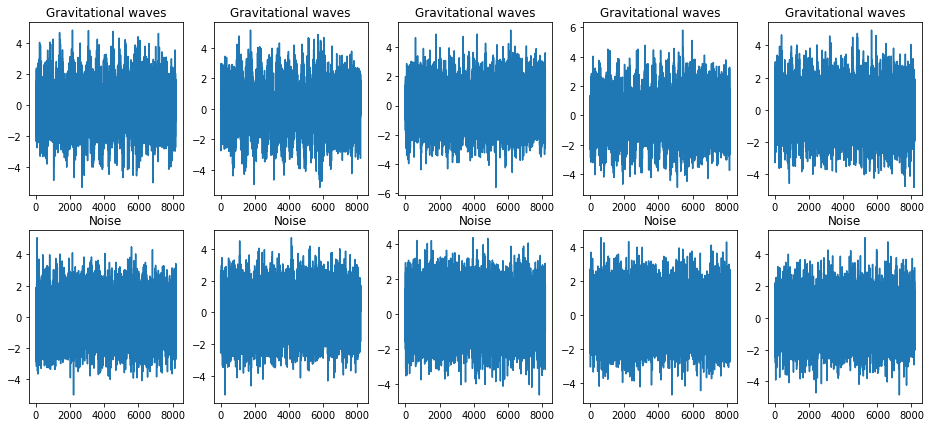

In [ ]:
fig, axes = plt.subplots(2, 5, figsize = (16, 7))

for i in range(2):
    sub_idx = np.where(y_train == i)[0]
    for j in range(5):
        axes[i][j].plot(x_train[sub_idx[j]])
        axes[i][j].set_title('Gravitational waves' if i ==0 else 'Noise')

---

# 2. Build the network

We will build a support vector machine (SVM) and a 1D-convolutional neural network to compare their results.



### Support Vector Machine

Use SVM from sklearn library.

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
# fit linear regression model
model = svm.SVC().fit(x_train.reshape(-1, 8192), y_train)
# make predictions
y_train_pred = model.predict(x_train.reshape(-1, 8192))
y_test_pred = model.predict(x_test.reshape(-1, 8192))
```
    
</p>
</details>

In [ ]:
# fit linear regression model
model = svm.SVC().fit(x_train.reshape(-1, 8192), y_train)
# make predictions
y_train_pred = model.predict(x_train.reshape(-1, 8192))
y_test_pred = model.predict(x_test.reshape(-1, 8192))

In [ ]:
# compute some fitting error
print('Accuracy on the train set = %f ' % metrics.accuracy_score(y_train, y_train_pred))
print('Accuracy on the test set = %f ' % metrics.accuracy_score(y_test, y_test_pred))

Accuracy on the train set = 1.000000 
Accuracy on the test set = 0.960000 


### Build a Neural Network

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
model = Sequential()
model.add(Input(shape=(x_train.shape[1],1,)))

model.add(Conv1D(filters=16, kernel_size=7, strides = 2, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Conv1D(filters=32, kernel_size=7, strides = 2, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(Dropout(0.2))

model.add(Dense(1, activation = "sigmoid"))        

opt = tf.keras.optimizers.Adam(0.0001)
model.compile(loss="binary_crossentropy", optimizer=opt)



stopper=EarlyStopping(monitor ="val_loss", min_delta=0.0,verbose=1,
                      mode="min", restore_best_weights=True,patience=5)
history = model.fit(x_train, y_train, epochs=99, batch_size=64, 
                             validation_split=0.2,callbacks=[stopper])
```
    
</p>
</details>

In [ ]:
model = Sequential()
model.add(Input(shape=(x_train.shape[1],1,)))

model.add(Conv1D(filters=16, kernel_size=7, strides = 2, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Conv1D(filters=32, kernel_size=7, strides = 2, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(Dropout(0.2))

model.add(Dense(1, activation = "sigmoid"))        

opt = tf.keras.optimizers.Adam(0.0001)
model.compile(loss="binary_crossentropy", optimizer=opt)



stopper=EarlyStopping(monitor ="val_loss", min_delta=0.0,verbose=1,
                      mode="min", restore_best_weights=True,patience=5)
history = model.fit(x_train, y_train, epochs=99, batch_size=64, 
                             validation_split=0.2,callbacks=[stopper])

Epoch 1/99
20/20 [==============================] - 10s 454ms/step - loss: 1.0019 - val_loss: 0.6414
Epoch 2/99
20/20 [==============================] - 9s 435ms/step - loss: 0.6125 - val_loss: 0.5556
Epoch 3/99
20/20 [==============================] - 9s 433ms/step - loss: 0.4835 - val_loss: 0.4275
Epoch 4/99
20/20 [==============================] - 9s 434ms/step - loss: 0.3356 - val_loss: 0.2978
Epoch 5/99
20/20 [==============================] - 9s 453ms/step - loss: 0.2117 - val_loss: 0.1952
Epoch 6/99
20/20 [==============================] - 9s 439ms/step - loss: 0.1245 - val_loss: 0.1406
Epoch 7/99
20/20 [==============================] - 10s 486ms/step - loss: 0.0769 - val_loss: 0.0974
Epoch 8/99
20/20 [==============================] - 14s 690ms/step - loss: 0.0525 - val_loss: 0.0879
Epoch 9/99
20/20 [==============================] - 9s 437ms/step - loss: 0.0343 - val_loss: 0.0644
Epoch 10/99
20/20 [==============================] - 9s 437ms/step - loss: 0.0248 - val_loss: 0.0

---

# 3. Analyse results 

### prediction

We used the sigmoid function. Hence, the label will be 1 if the output is greater than 0.5 and 0 otherwise.

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

y_train_pred = np.where(y_train_pred>0.5, 1., 0.)
y_test_pred = np.where(y_test_pred>0.5, 1., 0.)
```
    
</p>
</details>

In [ ]:
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

y_train_pred = np.where(y_train_pred>0.5, 1., 0.)
y_test_pred = np.where(y_test_pred>0.5, 1., 0.)

In [ ]:
# compute some fitting error
print('Accuracy on the train set = %f ' % metrics.accuracy_score(y_train, y_train_pred.reshape(-1)))
print('Accuracy on the test set = %f ' % metrics.accuracy_score(y_test, y_test_pred.reshape(-1)))

MSE on the train set = 0.997500 
MSE on the test set = 0.995000 


In [ ]:
agree_idxs = np.where(y_test == y_test_pred.reshape(-1))[0]
disagree_idxs = np.where(y_test!=y_test_pred.reshape(-1))[0]

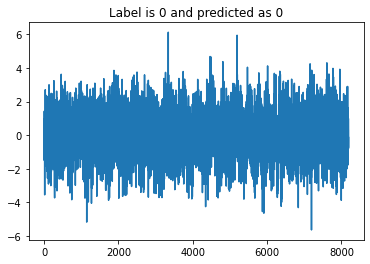

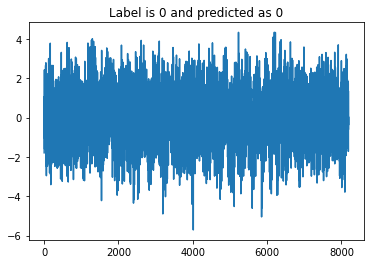

In [ ]:
for _ in range(len(disagree_idxs)):
    agree_idx = np.random.choice(len(agree_idxs), 1)[0]
    plt.figure()
    plt.plot(x_test[agree_idx])
    plt.title('Label is {} and predicted as {}'.format(y_test[agree_idx], int(y_test_pred[agree_idx][0])))

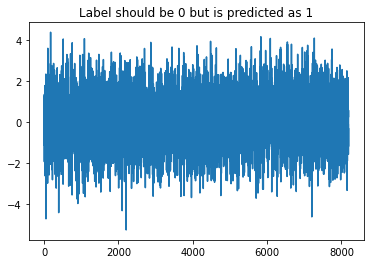

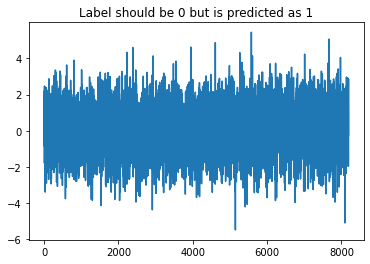

In [ ]:
for disagree_idx in disagree_idxs:
    plt.figure()
    plt.plot(x_test[disagree_idx])
    plt.title('Label should be {} but is predicted as {}'.format(y_test[disagree_idx], int(y_test_pred[disagree_idx][0])))

---

# 4. Exercises

* Change some hyperparameters in `model.compile()` and `model.fit()` to see their effects (see reference of [tf.keras.Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model)); 
* Change the architeture and activation functions of neural networks to improve the accuracy